## Data access:

BII data: This dataset is part of the MPC STAC catalog. You will need to access the ‘io-biodiversity’ collection and look for the 2017 and 2020 rasters covering Phoenix subdivision. You can use the following coordinates for a bounding box: 
- [-112.826843, 32.974108, -111.184387, 33.863574]


Phoenix subdivision: You will find the Phoenix subdivision polygon in the Census County Subdivision shapefiles for Arizona: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions


In [18]:
import pandas as pd
import numpy as np
import geopandas as gpd
import rioxarray as rioxr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # for creating legends
import os 

from shapely.geometry import Polygon

# used to access STAC catalogs
from pystac_client import Client
# used to sign items from the MPC STAC catalog
import planetary_computer

# ----- other libraries for nice ouputs
from IPython.display import Image

In [4]:
# access catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [5]:
io_biodiversity_collection = catalog.get_child('io-biodiversity')
io_biodiversity_collection

<CollectionClient id=io-biodiversity>

In [6]:
# temporal range of interest
time_range = "2017-01-01/2020-01-01"
# spatial range of interest
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

search = catalog.search(collections=['io-biodiversity'], bbox=bbox, datetime=time_range)
items = search.get_all_items()
len(items)

/Users/melissawidas/opt/anaconda3/envs/mpc-env/lib/python3.11/site-packages/pystac_client/item_search.py:850: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


4

In [7]:
items

In [8]:
bii_2020 = items[0]

bii_2017 = items[3]

In [9]:
# print item id and properties for BII 2017
print('id:' , bii_2017.id)
bii_2017.properties

id: bii_2017_34.74464974521749_-115.38597824385106_cog


{'datetime': None,
 'proj:epsg': 4326,
 'proj:shape': [7992, 7992],
 'end_datetime': '2017-12-31T23:59:59Z',
 'proj:transform': [0.0008983152841195215,
  0.0,
  -115.38597824385106,
  0.0,
  -0.0008983152841195215,
  34.74464974521749,
  0.0,
  0.0,
  1.0],
 'start_datetime': '2017-01-01T00:00:00Z'}

In [10]:
# look at assets to find where data is stored
for key in bii_2017.assets.keys():
    print(key, '--', bii_2017.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [11]:
# load BII 2017 data
bii_2017_data = rioxr.open_rasterio(bii_2017.assets['data'].href)
type(bii_2017_data)

#Image(url=bii_2017.assets['rendered_preview'].href, width=500)

xarray.core.dataarray.DataArray

In [12]:
# load BII 2020 data
bii_2020_data = rioxr.open_rasterio(bii_2020.assets['data'].href)
bii_2020_data

<xarray.DataArray (band: 1, y: 7992, x: 7992)>
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57 27.57
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

<Axes: >

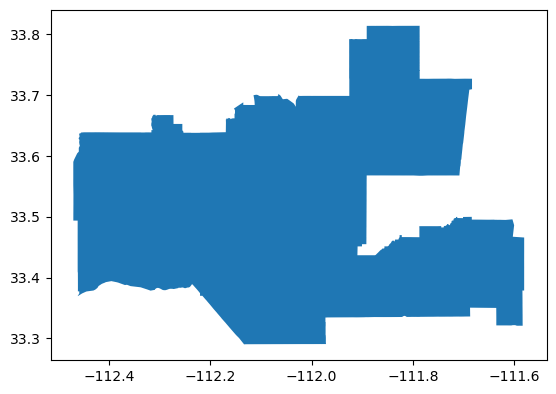

In [32]:
subdivisions = gpd.read_file(os.path.join(os.getcwd(), 'data', 'tl_2022_04_cousub','tl_2022_04_cousub.shp'))

phoenix = subdivisions[subdivisions.NAME=='Phoenix']

phoenix.plot()

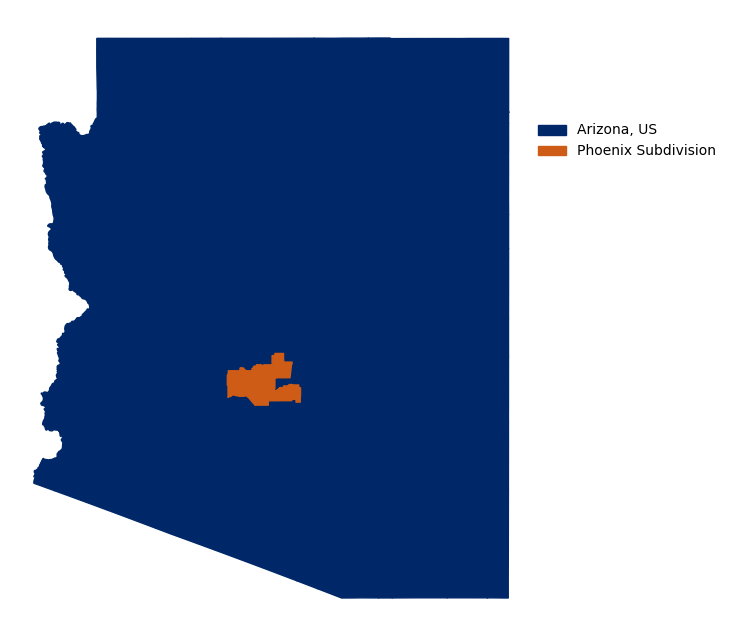

In [48]:

# create figure
fig, ax = plt.subplots(figsize=(12,8))

ax.axis('off')

subdivisions.plot(ax=ax,  # add outline of Arizona and subdivision outlines
       color='#002868',
       edgecolor = '#002868')
subdivisions_patch = mpatches.Patch(color='#002868',
                          label='Arizona, US')

phoenix.plot(ax=ax,   # highlight subdivision of pheonix
         color ='#CE5C17',
         edgecolor ='#CE5C17',
         label ='Phoenix Subdivision')
phoenix_patch = mpatches.Patch(color='#CE5C17',
                            label='Phoenix Subdivision')

ax.legend(handles = [subdivisions_patch, phoenix_patch], frameon=False, loc=(1, 0.75))

plt.show()

Create a map showing the Phoenix subdivision within an appropriate geographical context. You may use any vector datasets to create your map. (You can also check out the contextily package.)

Calculate the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017. Obtain the same calculation for 2020.

HINTS (useful or not depending on your workflow): 
    
- Let x be an xarray.DataArray. We can select all the values greater than n by simply doing x>n. This will return an xarray.DataArray with boolean values. You can then transform this into an xarray.DataArray with 0s and 1s (instead of True/False) by casting it as type ‘int’. 
- To calculate the percentage area: (pixels in class)/(total pixels) * 100. 



Create a visualization showing the area with BII>=0.75 in 2017 that was lost by 2020. Here’s an example:
